# Sales Forecasting

At its core, a business's entire goal is to maximize one function: the profit function ($revenue - cost = profit$). Sounds easy, right? Unfortuneately, we live in a complex world with complex economies at multiple levels: global, national, state/province, city, and even neighborhood. This complexity creates risk, which means that there is an opportunity cost for every decision a business makes. Minimizing those opportunity costs is often best done through planning for the future. Just like it's wise to have a budget, track your personal expenses, and plan for the future, a business is only as successful as its ability to plan. One of the most common types of business planning is sales forecasting: the process of predicting future sales based on historical data, market trends, and economic conditions. Sales forecasting serves as a critical planning tool that helps businesses predict demand, maximize resource allocation efficiency, and set realistic financial and operational goals (the latter being especially crucial for public companies). Accurate sales forecasting enables companies to manage inventory, optimizing staffing, and align marketing and production efforts with anticipated demand, all leading to minimized opportunity costs. By identifying trends and potential shortfalls early, businesses can proactively address challenges, capitalize on opportunities, and make informed data-driven decisions that reduce risk and increase leverage.

Sales forecasting was historically done with manual methods and basic statistical techniques like trend analysis and moving averages. These approaches were simple due to the limited computing power of the day, and often didn't account for external factors like seasonality or market changes. As compute cost grew cheaper and cheaper, more sophisticated methods were introduced: regression models, time series analysis (ARIMA), and machine learning models. Today, the latest and greatest forecasting leverages advanced data modelling and representation techniques, which enable a statistical model to capture complex patterns and relationships in massive, high dimensional datasets. Even more recently, innovations like RNNs and transformers have enabled businesses to model external variables like macroeconomic trends, customer sentiment, and even weather data!

In this notebook, we'll look at xyz different methods of sales forecasting for retail stores, starting with the simplest and growing to the most complex:
1. Linear Regression Model
2. Time Series Models: SARIMA
3. Smoothing Models: Holt-Winters
4. Ensemble Architechtures: Random Forest/XGBoost
5. Deep Learning Architechtures: LSTM/Transformer
6. Bonus: Prophet by Meta

## Importing Libraries and Data

We'll be using one dataset throughout this whole notebook: the Rossman Store Sales dataset, from a 2015 Kaggle competition hosted by Rossman. You can find the overview [here](https://www.kaggle.com/competitions/rossmann-store-sales/overview). 

Rossman is a pharmacy chain with about 3,000 stores across 7 European countries. We want to forecast sales for 6 weeks into the future for each of the stores represented in our dataset.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_style('whitegrid')

from tqdm import tqdm

import datetime
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("train.csv", parse_dates=[2])
store_data = pd.read_csv("store.csv")
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [3]:
df.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday'],
      dtype='object')

In [4]:
store_data.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270,9,2008,0,,,NaN
1,2,a,a,570,11,2007,1,13,2010,"Jan,Apr,Jul,Oct"
2,3,a,a,14130,12,2006,1,14,2011,"Jan,Apr,Jul,Oct"
3,4,c,c,620,9,2009,0,,,NaN
4,5,a,a,29910,4,2015,0,,,NaN


Our primary data source has 9 columns:
1. Store: store ID
2. DayOfWeek: Day of the week represented (1 = Monday, 7 = Sunday)
3. Date: Date of sales represented
4. Sales: Amount of sales in Euros
5. Customers: Count of customers in the store
6. Open: Binary 0/1 representing whether or not the store was open
7. Promo: Binary 0/1 representing whether or not the store was running a promo
8. StateHoliday: Represents whether or not the date was a state holiday: a = public holiday, b = Easter, c = Christmas, 0 = None
9. SchoolHoliday: Binary 0/1 representing whether or not (Store @ Date)'s schools were closed

We also have a 'store' data source that contains info about each store location:
1. Store: Store ID
2. StoreType: Represents 4 different store models: a, b, c, d
3. Assortment: Represents level of inventory assortment/diversity: a = basic, b = extra, c = extended
4. CompetitionDistance: Distance in meters to the nearest competitor store
5. CompetitionOpenSinceMonth: Month that the nearest competitor store was opened
6. CompetitionOpenSinceYear: Year that the nearest competitor store was opened
7. Promo2: Indicates participation in a continuing and consecutive promotion
8. Promo2SinceWeek: Week that the store started Promo2
9. Promo2SinceYear: Year that the store started Promo2
10. PromoInterval: Represents the consecutive intervals Promo2 is started (Feb, May, Aug means that the promo starts anew in Feb, May, and Aug)

## Preprocessing

Let's start by looking at the distribution of each variable and checking for nulls: 

In [5]:
df.describe()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1017209,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,2014-04-11 01:30:42.846061824,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
min,1.000000e+00,1.000000e+00,2013-01-01 00:00:00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,2013-08-17 00:00:00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,2014-04-02 00:00:00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,2014-12-12 00:00:00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,2015-07-31 00:00:00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00
std,3.219087e+02,1.997391e+00,NaN,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01


In [6]:
df.isnull().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

We're dealing with time series data, so it's a good idea to set the Date column to be the df index. We'll also split up the date into separate year, month, and day features: 

In [7]:
df.set_index('Date', inplace=True)

df['Year'] = df.index.year
df['Month'] = df.index.month
df['Day'] = df.index.day
df['WeekOfYear'] = df.index.strftime("%V")
df['WeekOfYear'] = pd.to_numeric(df['WeekOfYear'], errors='coerce')

df.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear
Date,,,,,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1,2015,7,31,31
2015-07-31,2,5,6064,625,1,1,0,1,2015,7,31,31
2015-07-31,3,5,8314,821,1,1,0,1,2015,7,31,31
2015-07-31,4,5,13995,1498,1,1,0,1,2015,7,31,31
2015-07-31,5,5,4822,559,1,1,0,1,2015,7,31,31


Let's also check out the store data source:

In [8]:
store_data.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            0
CompetitionOpenSinceMonth      0
CompetitionOpenSinceYear       0
Promo2                         0
Promo2SinceWeek                0
Promo2SinceYear                0
PromoInterval                544
dtype: int64

Looks like we have some missing data in PromoInterval. Let's just impute an empty string there:

In [9]:
store_data['PromoInterval'].fillna("", inplace=True)
store_data.isnull().sum()

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

In [10]:
store_data.dtypes

Store                         int64
StoreType                    object
Assortment                   object
CompetitionDistance          object
CompetitionOpenSinceMonth    object
CompetitionOpenSinceYear     object
Promo2                        int64
Promo2SinceWeek              object
Promo2SinceYear              object
PromoInterval                object
dtype: object

In [11]:
for col in store_data.columns:
    print(f"{col}:\n {store_data[col].unique()}")

Store:
 [   1    2    3 ... 1113 1114 1115]
StoreType:
 ['c         ' 'a         ' 'd         ' 'b         ']
Assortment:
 ['a          ' 'c          ' 'b          ']
CompetitionDistance:
 ['1270' '570' '14130' '620' '29910' '310' '24000' '7520' '2030' '3160'
 '960' '1070' '1300' '4110' '3270' '50' '13840' '3240' '2340' '550' '1040'
 '4060' '4590' '430' '2300' '60' '1200' '2170' '40' '9800' '2910' '1320'
 '2240' '7660' '540' '4230' '1090' '260' '180' '1180' '290' '4880' '9710'
 '270' '1060' '18010' '6260' '10570' '450' '30360' '7170' '720' '6620'
 '420' '7340' '2840' '5540' '350' '2050' '3700' '22560' '410' '250' '1130'
 '4840' '17500' '2200' '1650' '330' '22440' '19960' '3510' '3320' '7910'
 '2370' '22390' '2710' '11810' '1870' '480' '560' '10690' '2380' '2410'
 '240' '16690' '14620' '1890' '8780' '8980' '15140' '17930' '2440' '150'
 '5210' '390' '6190' '1390' '1930' '2190' '3300' '46590' '7890' '1630'
 '20930' '4510' '5740' '680' '3450' '3580' '2100' '2290' '3570' '58260'
 '16760' '1

Looks like multiple columns have values with significant whitespace. Let's strip that out and impute the mean value if the col is intended to be numeric:

In [12]:
whitespace_str_cols = ['StoreType', 'Assortment']
whitespace_num_cols = ['CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2SinceWeek', 'Promo2SinceYear']

valid_str_values = {"a", "b", "c", "d"}

# Loop through the columns and coerce the values
for col in whitespace_str_cols:
    store_data[col] = store_data[col].apply(lambda x: next((v for v in valid_str_values if v in str(x).lower()), np.nan))
    print(f"{col}:\n {store_data[col].unique()}")

for col in whitespace_num_cols:
    store_data[col] = store_data[col].replace(['                         ', '                    ', '                '], np.nan)
    store_data[col] = store_data[col].apply(pd.to_numeric, errors='coerce')
    store_data[col] = store_data[col].fillna(round(store_data[col].mean()))
    store_data[col] = store_data[col].astype(int)
    print(f"{col}:\n {store_data[col].unique()}")

StoreType:
 ['c' 'a' 'd' 'b']
Assortment:
 ['a' 'c' 'b']
CompetitionDistance:
 [ 1270   570 14130   620 29910   310 24000  7520  2030  3160   960  1070
  1300  4110  3270    50 13840  3240  2340   550  1040  4060  4590   430
  2300    60  1200  2170    40  9800  2910  1320  2240  7660   540  4230
  1090   260   180  1180   290  4880  9710   270  1060 18010  6260 10570
   450 30360  7170   720  6620   420  7340  2840  5540   350  2050  3700
 22560   410   250  1130  4840 17500  2200  1650   330 22440 19960  3510
  3320  7910  2370 22390  2710 11810  1870   480   560 10690  2380  2410
   240 16690 14620  1890  8780  8980 15140 17930  2440   150  5210   390
  6190  1390  1930  2190  3300 46590  7890  1630 20930  4510  5740   680
  3450  3580  2100  2290  3570 58260 16760  1410   760  3370  1350  2000
  2460   900   920  5190  1730 25360  1700  1540  2930 16570   280  8050
  8540  2090  2610 31830  4360  1780 16240 16420  3050  2020  2950 11840
  8530 17110  2970  5340  1480  1160  3720   

While we're at it, let's check our main df for excessive whitespace:

In [13]:
for col in df.columns:
    print(f"{col}: {df[col].unique()}")

Store: [   1    2    3 ... 1113 1114 1115]
DayOfWeek: [5 4 3 2 1 7 6]
Sales: [ 5263  6064  8314 ...   660 17815 23303]
Customers: [ 555  625  821 ... 3900   36 4065]
Open: [1 0]
Promo: [1 0]
StateHoliday: ['0' 'a            ' 'b            ' 'c            ' 0]
SchoolHoliday: [1 0]
Year: [2015 2014 2013]
Month: [ 7  6  5  4  3  2  1 12 11 10  9  8]
Day: [31 30 29 28 27 26 25 24 23 22 21 20 19 18 17 16 15 14 13 12 11 10  9  8
  7  6  5  4  3  2  1]
WeekOfYear: [31 30 29 28 27 26 25 24 23 22 21 20 19 18 17 16 15 14 13 12 11 10  9  8
  7  6  5  4  3  2  1 52 51 50 49 48 47 46 45 44 43 42 41 40 39 38 37 36
 35 34 33 32]


Looks like StateHoliday has the same problem. Let's fix those values in the same way:

In [14]:
valid_state_holiday_values = {"0", "a", "b", "c"}
df['StateHoliday'] = df['StateHoliday'].apply(lambda x: next((v for v in valid_state_holiday_values if v in str(x).lower()), np.nan))
print(f"StateHoliday: {df['StateHoliday'].unique()}")

StateHoliday: ['0' 'a' 'b' 'c']


Finally, let's merge everything together:

In [15]:
full_data = pd.merge(df, store_data, how='inner', on='Store') # merge data if store data is available
full_data.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,...,WeekOfYear,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,5263,555,1,1,0,1,2015,7,...,31,c,a,1270,9,2008,0,24,2012,
1,2,5,6064,625,1,1,0,1,2015,7,...,31,a,a,570,11,2007,1,13,2010,"Jan,Apr,Jul,Oct"
2,3,5,8314,821,1,1,0,1,2015,7,...,31,a,a,14130,12,2006,1,14,2011,"Jan,Apr,Jul,Oct"
3,4,5,13995,1498,1,1,0,1,2015,7,...,31,c,c,620,9,2009,0,24,2012,
4,5,5,4822,559,1,1,0,1,2015,7,...,31,a,a,29910,4,2015,0,24,2012,


## EDA

We know that there are 4 different types of stores, so let's see how Sales is distributed amongst each store type:

In [16]:
full_data.groupby('StoreType')['Sales'].describe()

,count,mean,std,min,25%,50%,75%,max
StoreType,,,,,,,,
a,551627.0,5738.179710,3964.028134,0.0,3508.0,5618.0,7860.00,41551.0
b,15830.0,10058.837334,5280.525506,0.0,6227.0,9025.5,13082.75,38722.0
c,136840.0,5723.629246,3721.700886,0.0,3789.0,5766.0,7849.00,31448.0
d,312912.0,5641.819243,3473.393781,0.0,3986.0,5826.0,7691.00,38037.0


StoreType b has almost double the average sales of the other store types, but we have far fewer stores of that type. StoreType a is the most common, and also has the highest max Sales value. Let's check overall totals of Sales and Customers across store types:

In [17]:
full_data.groupby('StoreType')[['Customers', 'Sales']].sum()

,Customers,Sales
StoreType,,
a,363541434,3165334859
b,31465621,159231395
c,92129705,783221426
d,156904995,1765392943


Clearly, store type a is the busiest and generates the most sales, and type d is a distant second. What about date ranges?

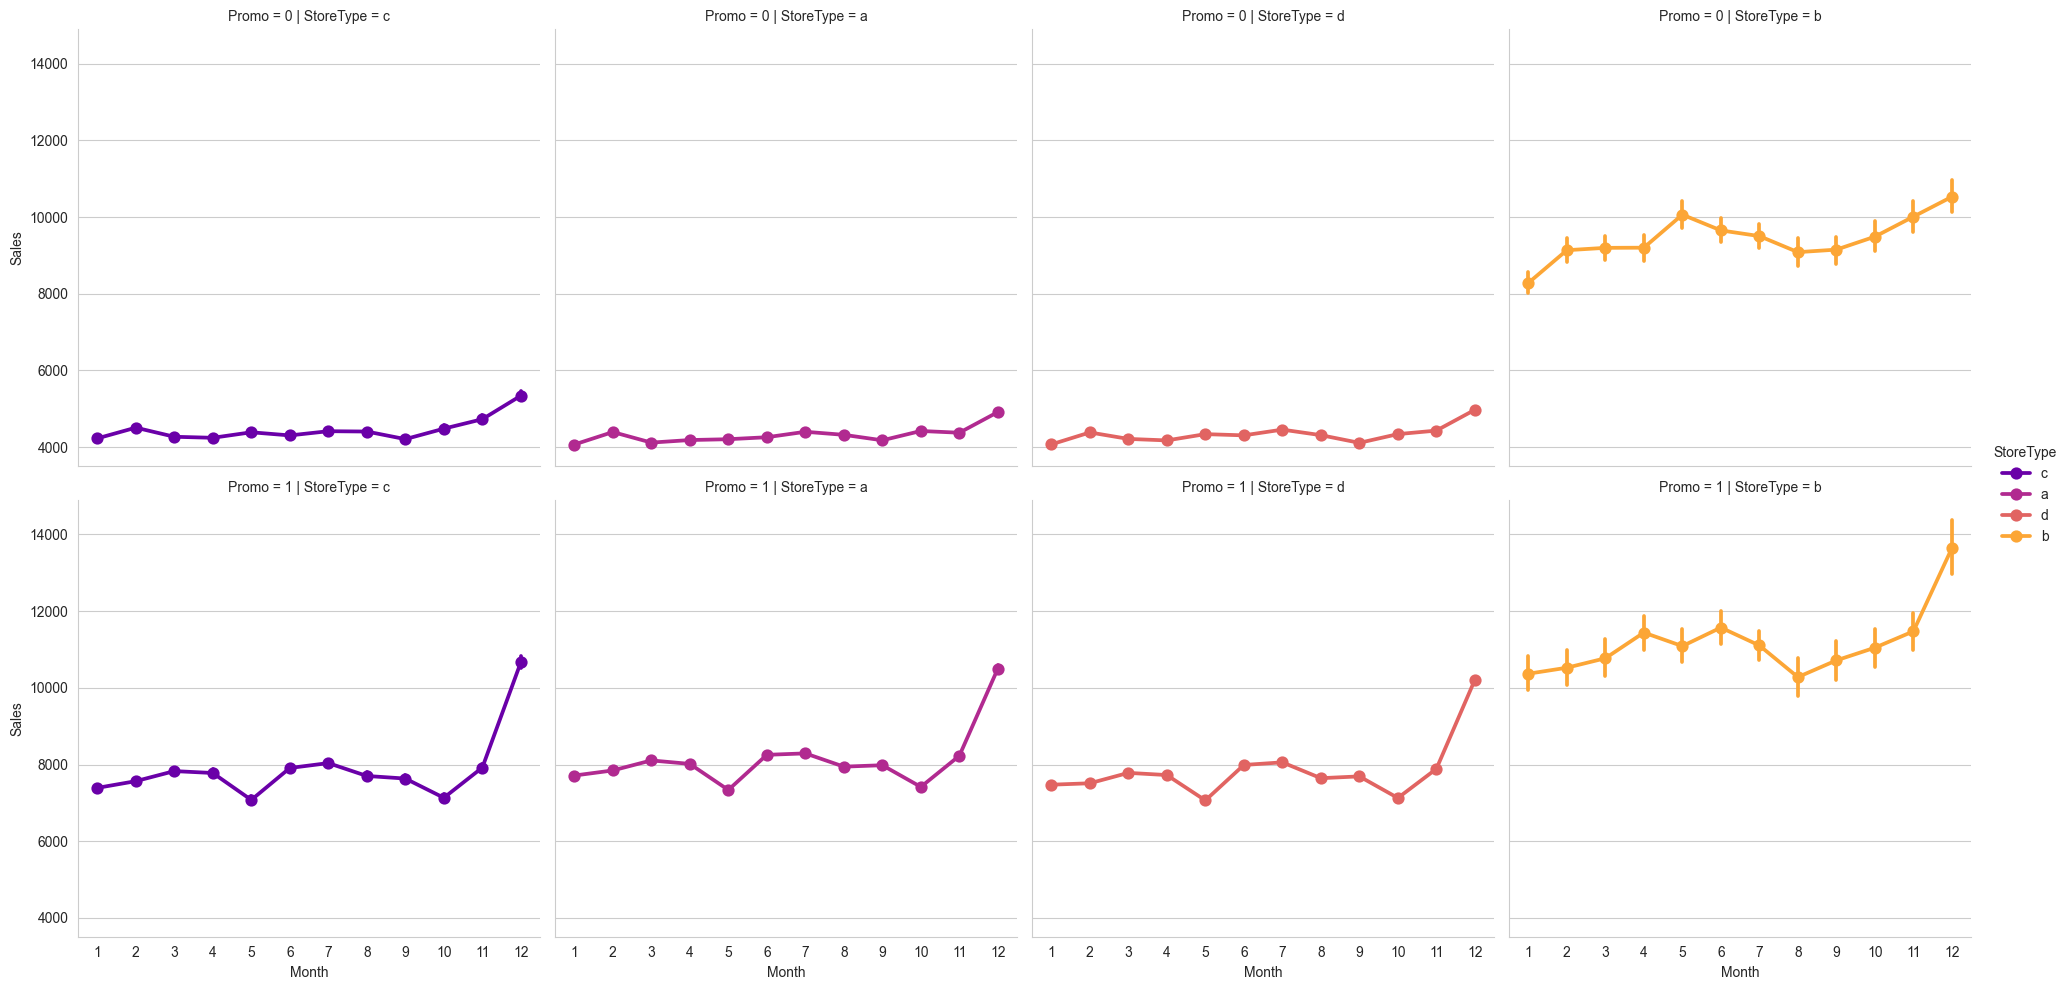

In [18]:
sns.catplot(data = full_data, x = 'Month', y = "Sales", 
            kind="point",
            col = 'StoreType', # store type in cols
            palette = 'plasma',
            hue = 'StoreType',
            row = 'Promo') # promo in rows

Let's do a quick check on sales per customer:

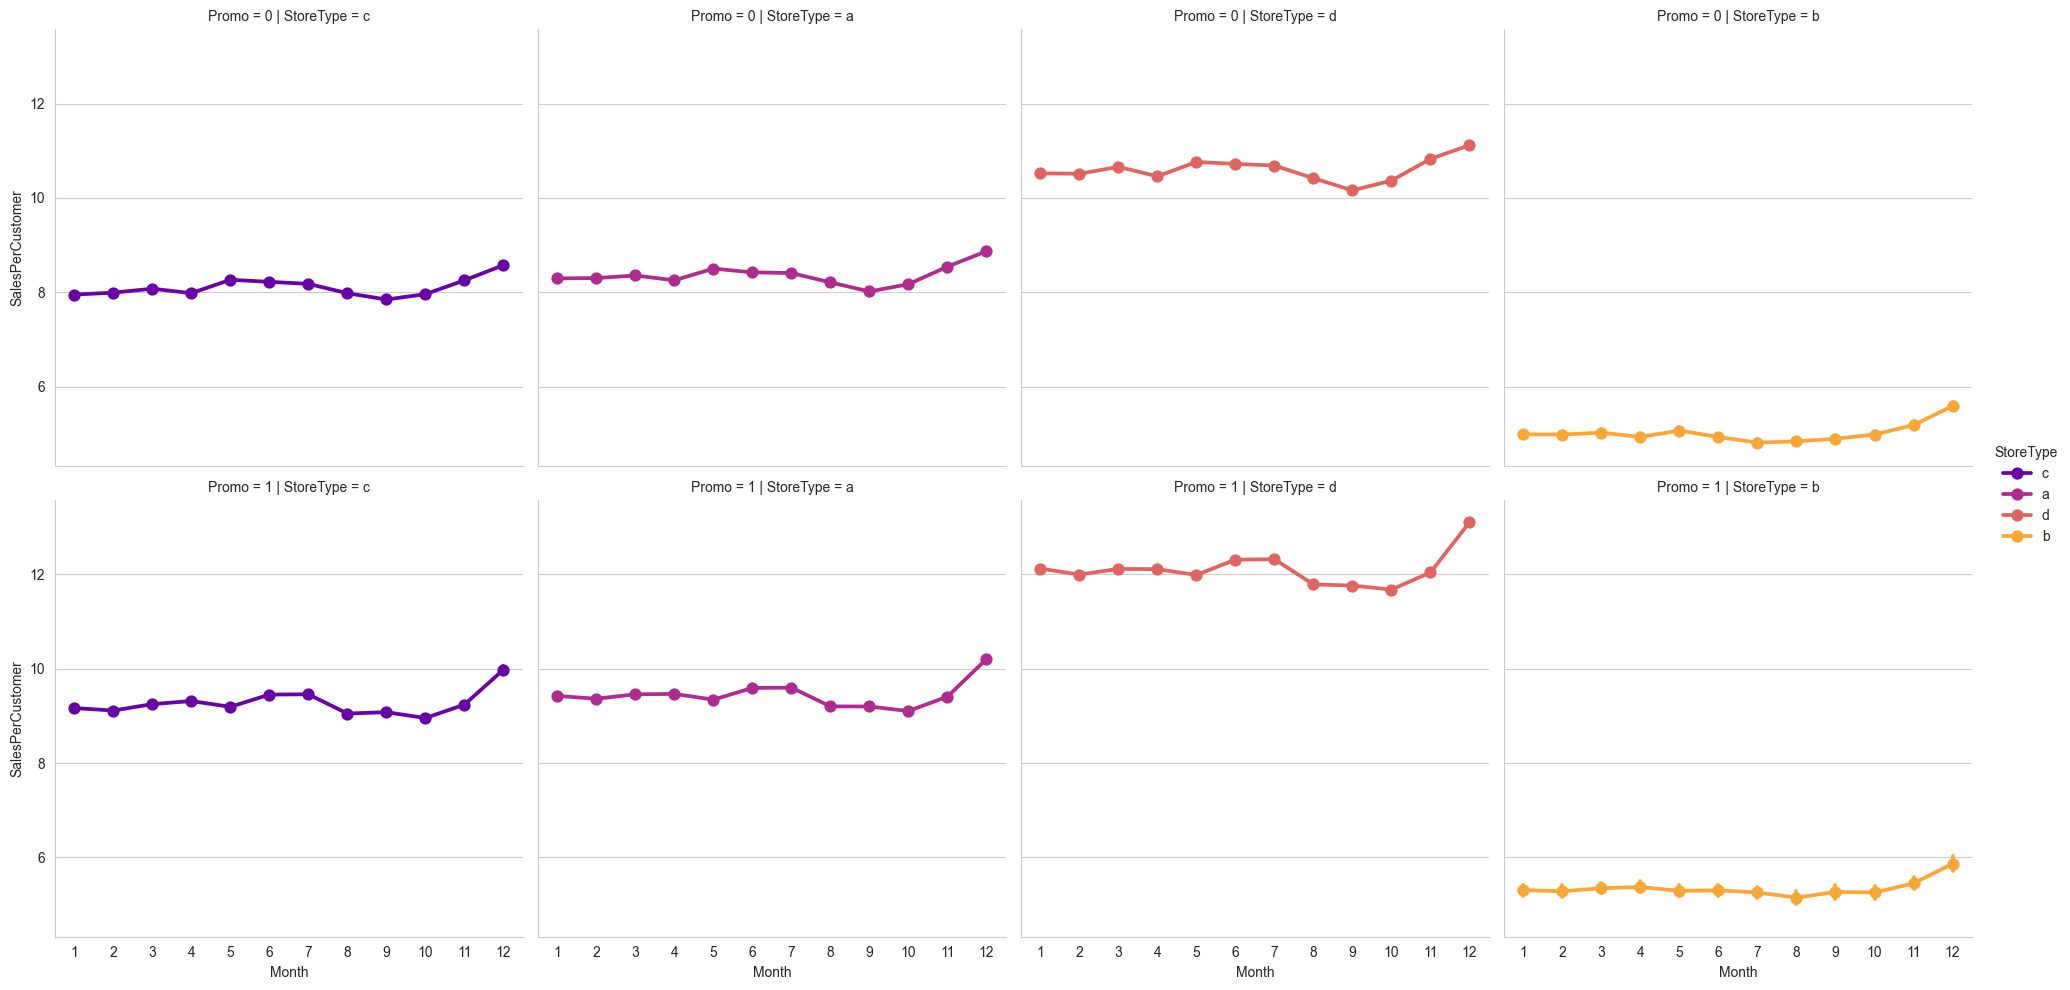

In [19]:
full_data['SalesPerCustomer'] = full_data['Sales'] / full_data['Customers']

sns.catplot(data = full_data, x = 'Month', y = "SalesPerCustomer", 
            kind="point",
            col = 'StoreType', # store type in cols
            palette = 'plasma',
            hue = 'StoreType',
            row = 'Promo') # promo in rows

Ah, this is interesting! Although store type a has the highest sales overall and highest customer traffic, store type d actually has the highest sales per customer: around 12 euros during promotions. Promotions clearer improve sales totals by a significant amount. Let's dive in deeper and look at sales across store types for each day of the week:

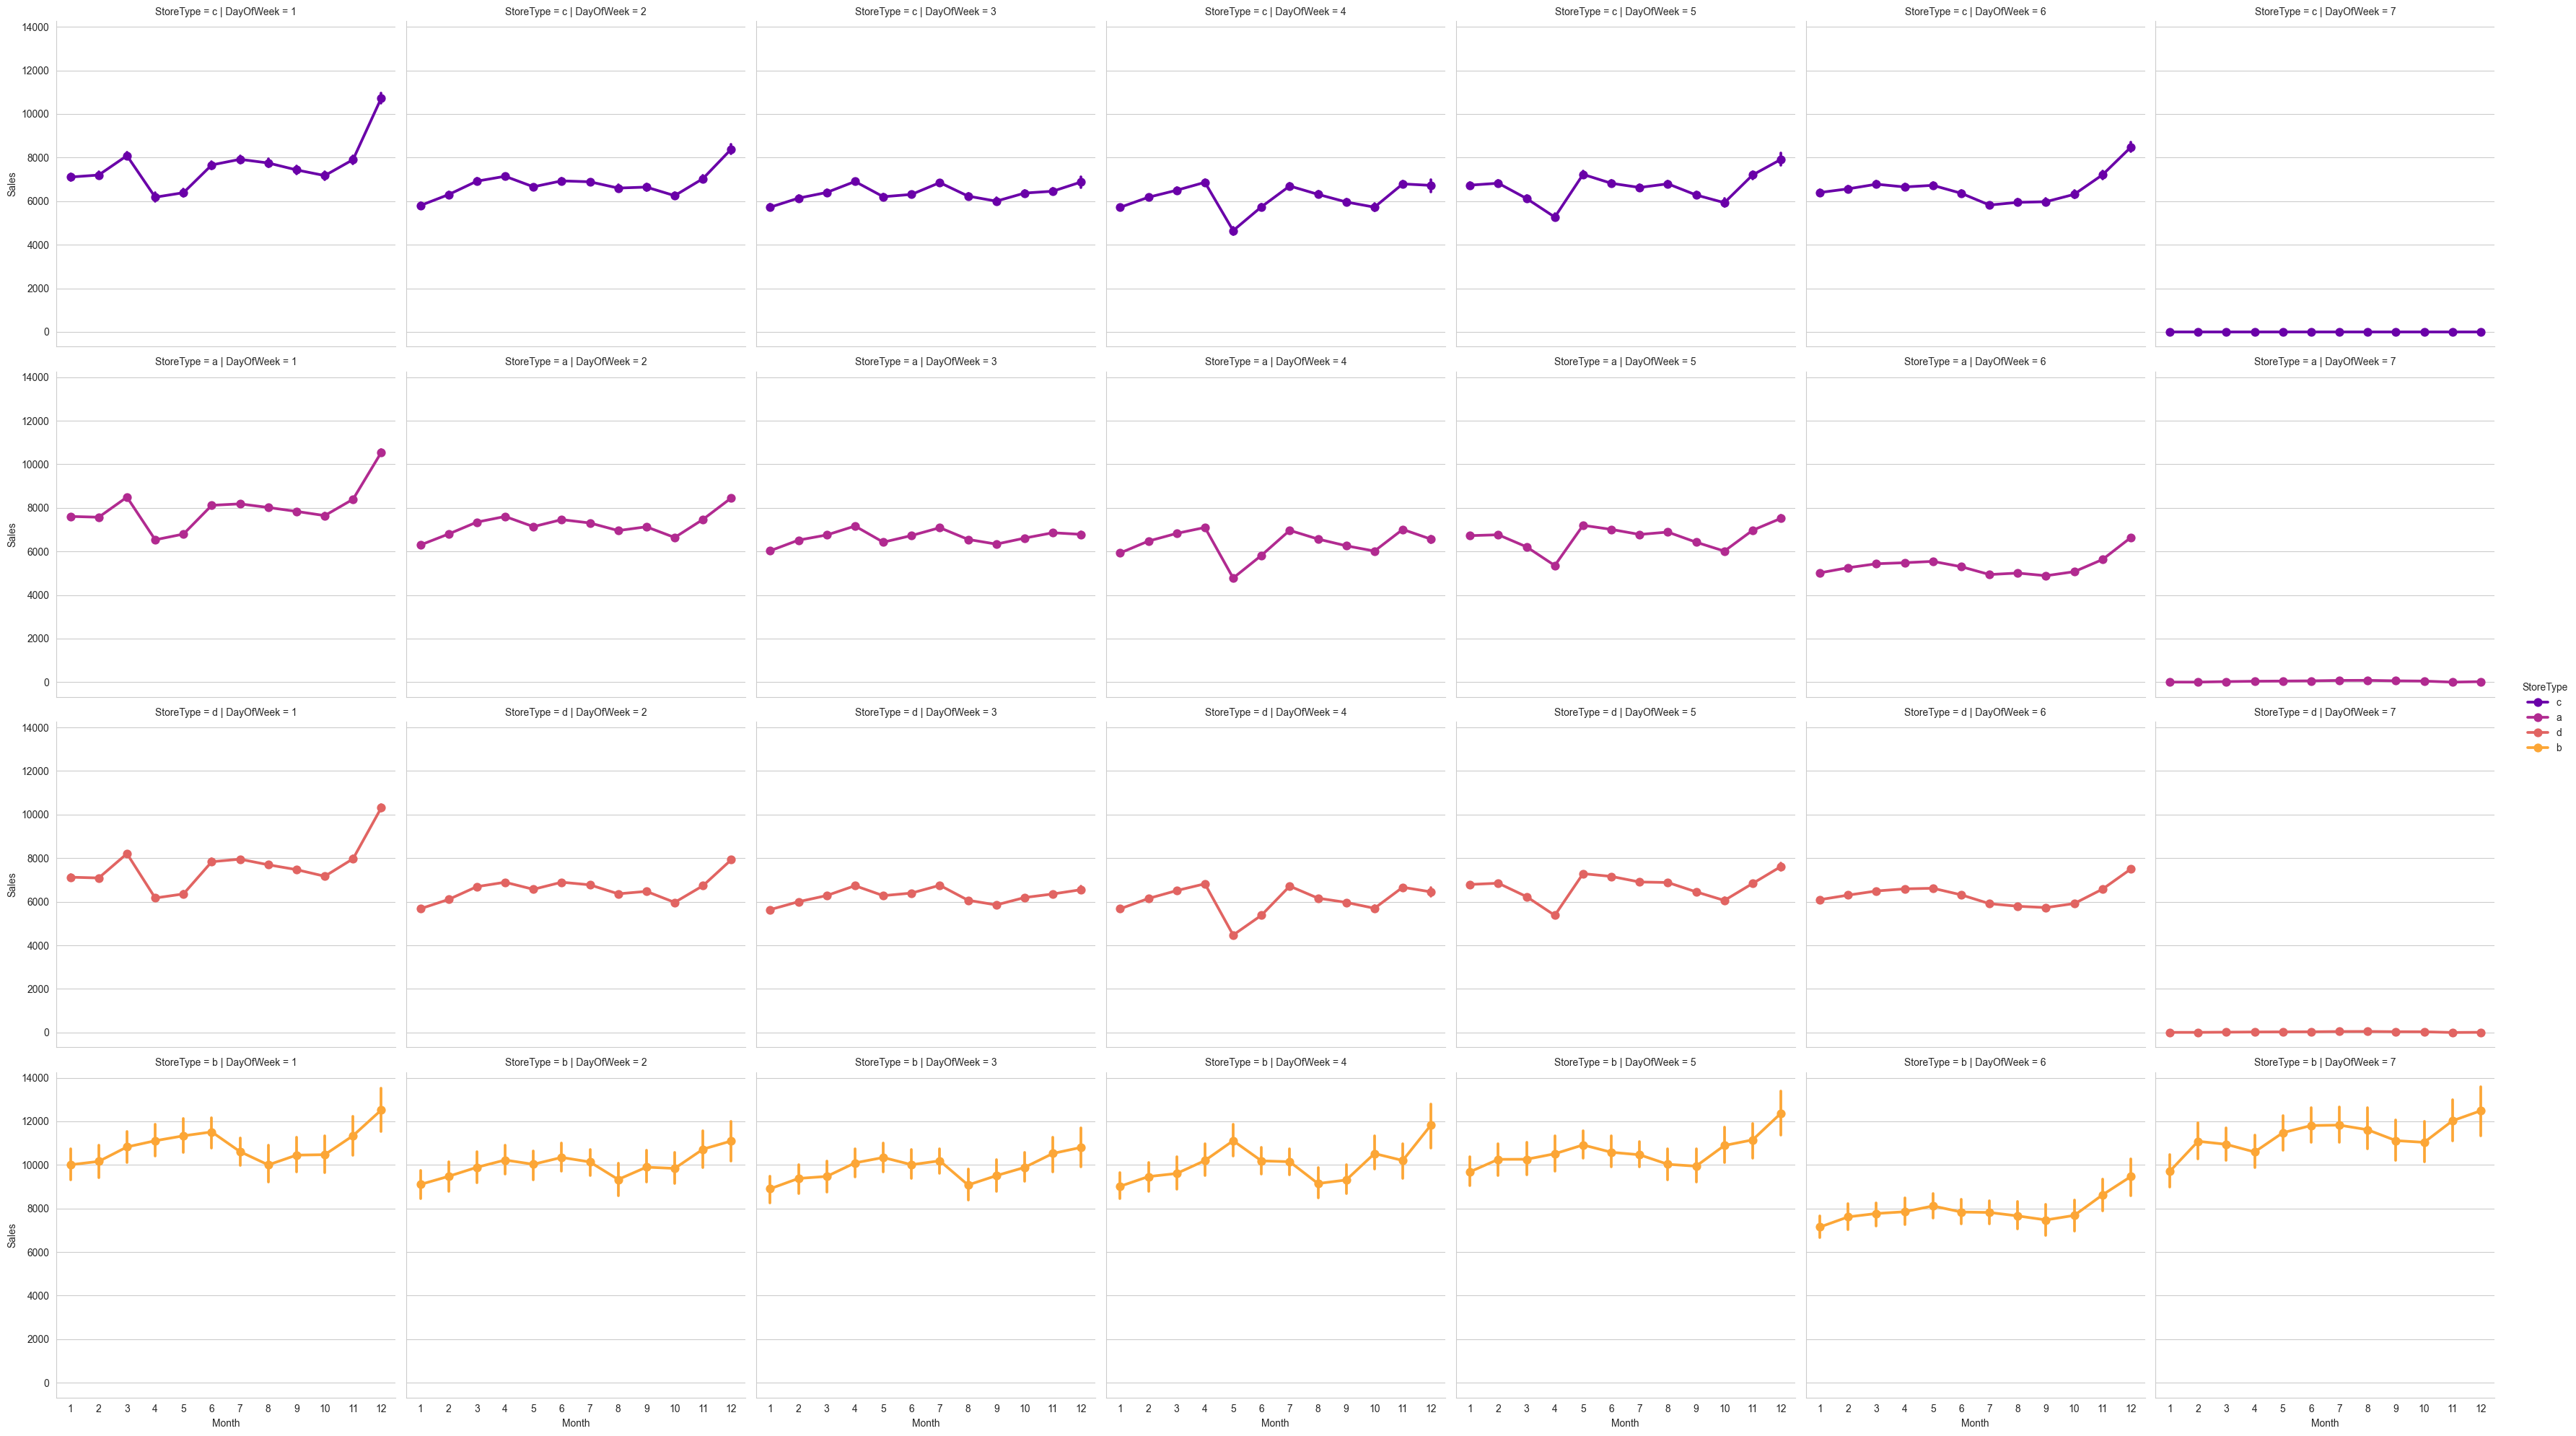

In [20]:
sns.catplot(data = full_data, x = 'Month', y = "Sales", 
            kind='point',
            col = 'DayOfWeek', # day of week in cols
            palette = 'plasma',
            hue = 'StoreType',
            row = 'StoreType') # store type in rows

Interesting--store type b is open on Sundays, while all other store types are closed. Store types a, c, and d all seem to follow similar trends across a year, but store type b runs its own course. 

Let's add some features to better represent exposure to competition and usage of promotions:

In [21]:
# competition open time (in months)
full_data['CompetitionOpen'] = 12 * (full_data['Year'] - full_data['CompetitionOpenSinceYear']) + \
        (full_data['Month'] - full_data['CompetitionOpenSinceMonth'])
    
# promo open time (in months)
full_data['PromoOpen'] = 12 * (full_data['Year'] - full_data['Promo2SinceYear']) + \
        (full_data['WeekOfYear'] - full_data['Promo2SinceWeek']) / 4.0

# replace NA's by 0
full_data.fillna(0, inplace = True)

# average PromoOpen time and CompetitionOpen time per store type
full_data.loc[:, ['StoreType', 'Sales', 'Customers', 'PromoOpen', 'CompetitionOpen']].groupby('StoreType').mean()

,Sales,Customers,PromoOpen,CompetitionOpen
StoreType,,,,
a,5738.179710,659.034880,22.733782,60.140551
b,10058.837334,1987.720846,19.416298,64.982502
c,5723.629246,673.265894,25.034833,61.154092
d,5641.819243,501.434892,24.281724,56.452955


Although store type b has the most sales and customer traffic, it's also the store type most exposed to competition; 5 years, 5 months on average! Type b stores are also newest to promotion participation, on average. Lastly, let's check correlation between each feature:

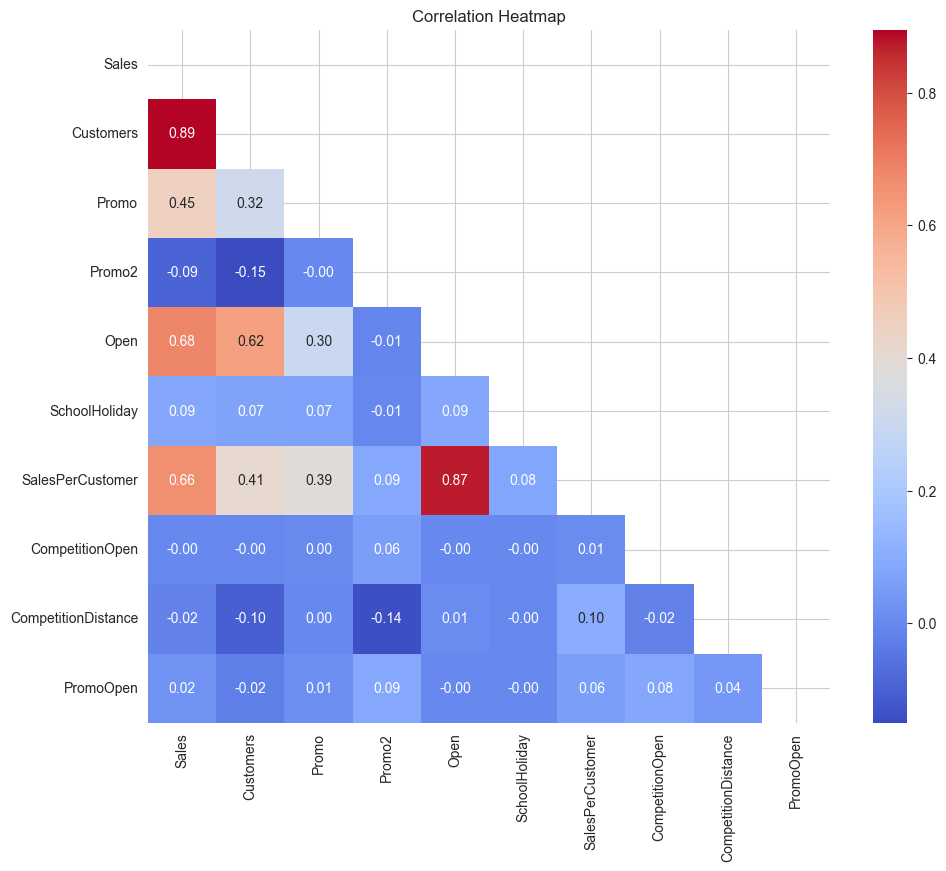

In [22]:
correlation_matrix = full_data[['Sales', 'Customers', 'Promo', 'Promo2', 'Open', 'SchoolHoliday', 'SalesPerCustomer', 'CompetitionOpen', 'CompetitionDistance', 'PromoOpen']].corr()
upper_mask = np.zeros_like(correlation_matrix, dtype = np.bool)
upper_mask[np.triu_indices_from(upper_mask)] = True

fig, ax = plt.subplots(figsize = (11, 9))
sns.heatmap(correlation_matrix, mask=upper_mask, annot=True, ax=ax, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

We can see that customers and sales are strongly correlated, which makes sense. More customers through the door generally correlates with higher sales. Promo and Sales are also correlated, which checks out. Notably, Promo2 (which indicates if the store is consecutively running a promo) is negatively correlated with sales! This indicates that when a store first starts offering a promo, sales and customer traffic goes up. But if they continue that promotion, sales and customer traffic starts to decrease. Let's see if this holds true at more granular levels, like successive days of the week:

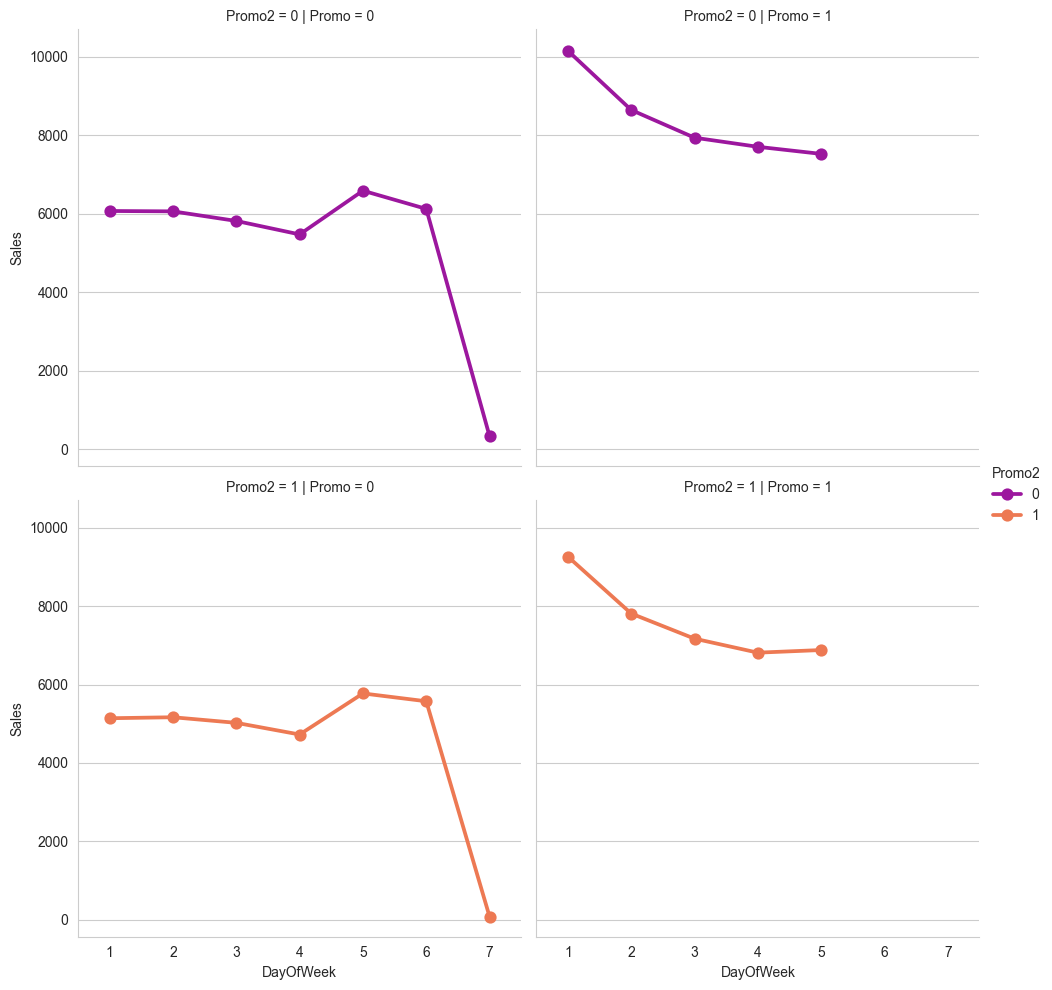

In [23]:
sns.catplot(data = full_data, x = 'DayOfWeek', y = "Sales", 
            kind='point',
            col = 'Promo', 
            row = 'Promo2',
            hue = 'Promo2',
            palette = 'plasma')

Indeed, a consecutive promo seems to decrease sales each successive day that the promo is run. With all of this in mind, let's start to build our forecasting models:

In [25]:
full_data.describe

<bound method NDFrame.describe of          Store  DayOfWeek  Sales  Customers  Open  Promo StateHoliday  \
0            1          5   5263        555     1      1            0   
1            2          5   6064        625     1      1            0   
2            3          5   8314        821     1      1            0   
3            4          5  13995       1498     1      1            0   
4            5          5   4822        559     1      1            0   
...        ...        ...    ...        ...   ...    ...          ...   
1017204   1111          2      0          0     0      0            a   
1017205   1112          2      0          0     0      0            a   
1017206   1113          2      0          0     0      0            a   
1017207   1114          2      0          0     0      0            a   
1017208   1115          2      0          0     0      0            a   

         SchoolHoliday  Year  Month  ...  CompetitionDistance  \
0                    1  